# Classificacao

[**Titanic**: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/)

# Sumario
0. [Carregando bibliotecas](#Carregando-bibliotecas)
1. [Carregando dados](#Carregando-dados)
2. [Preprocessamento](#Pre-processamento)
    1. [Remocao de atributo identificador](#Remocao-de-atributo-identificador)
    2. [Analise balanceamento](#Analisando-balanceamento)
    3. [Identificando dados ausentes](#Identificando-dados-ausentes)
    4. [Lidando com dados ausentes](#Lidando-com-dados-ausentes)
        1. [Embarked ausente](#Embarked-ausente)
        2. [Age ausente](#Age-ausente)
        3. [Cabin ausente](#Cabin-ausente)
    5. [Identificando atributos nao numericos](#Identificando-atributos-nao-numericos)
    6. [Lidando com atributos nao numericos](#Lidando-com-atributos-nao-numericos)
        1. [Sex e Embarked](#Sex-e-Embarked)
        2. [Name](#Name)
        3. [Ticket](#Ticket)
    7. [Identificando outliers](#Identificando-outliers)
        1. [Outliers em age](#Outliers-no-atributo-Age)
        2. [Outliers em fare](#Outliers-no-atributo-Fare)
    8. [Dividindo faixas de Age](#Dividindo-faixas-de-Age)
    9. [Dividindo faixas de Fare](#Dividindo-faixas-de-Fare)
    10. [Analise de correlacao](#Analise-de-correlacao)
        1. [Combinando SibSp e Parch](#Combinando-SibSp-e-Parch)
3. [Modelagem e treinamento](#Modelagem-e-treinamento)
    1. [Separando train e test](#Separando-train-e-test)
    2. [Testando arvore de decisao com Random Forest](#Testando-arvore-de-decisao-com-Random-Forest)
        1. [Aplicando classificador](#Aplicando-o-classificador)
        2. [Analizando resultados](#Analisando-resultados)
        3. [Otimizando altura da arvore](#Otimizando-altura-da-arvore)
        4. [Visualizando uma das arvores criadas](#Visualizando-uma-das-arvores-criadas)
        5. [Resultado final random forest](#Resultado-final-para-random-forest)
    3. [Testando classificacao com KNN](#Testando-classificacao-com-KNN)
        1. [Otimizando numero de vizinhos](#Otimizando-numero-de-vizinhos)
        2. [Resultado final KNN](#Resultado-final-KNN)
    4. [Comparando RandomForest e KNN](#Comparando-KNN-e-RandomForest)

# Carregando bibliotecas

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from subprocess import call
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np
import sklearn as sk 
from numpy import random
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import os
pd.options.display.max_rows = 2000
%matplotlib inline

# Carregando dados

In [4]:
df = pd.read_csv(os.path.join(os.path.abspath(''), "data/train.csv"))
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

# Pre-processamento

## Remocao de atributo identificador
O atributo `PassengerId` apenas identifica unicamente cada instancia de forma enumerada, logo se mostra irrelevante a qualquer analise

In [5]:
df.drop(columns=["PassengerId"], inplace=True)

## Analisando balanceamento

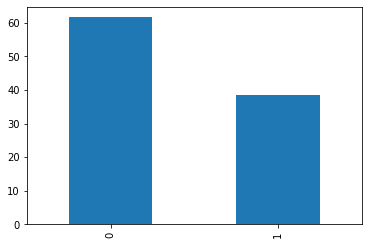

In [6]:
(df["Survived"].value_counts() / df.shape[0] * 100).plot.bar()

As instancias possuem apenas duas classes e essas estao suficientemente balanceadas.

## Identificando dados ausentes

In [7]:
df.isna().sum() / df.shape[0] * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

As colunas `Age`, `Cabin` e `Embarked` possuem dados faltando, o que tera de ser tratado adiante.

### Lidando com dados ausentes

#### `Embarked` ausente

In [8]:
df.loc[pd.isna(df["Embarked"])]

Survived  Pclass                                       Name     Sex  \
61          1       1                        Icard, Miss. Amelie  female   
829         1       1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   38.0      0      0  113572  80.0   B28      NaN  
829  62.0      0      0  113572  80.0   B28      NaN

Apenas 0.2% das instancias nao possuem o atributo `Embarked`, a remocao dessas instancias nao deve afetar drasticamente metricas associadas ao dataset.

In [9]:
# Remova as instancias com Embarked null
df.dropna(subset=["Embarked"],inplace=True)

#### `Age` ausente

In [10]:
df.corr().abs()["Age"]

Survived    0.082446
Pclass      0.365902
Age         1.000000
SibSp       0.307351
Parch       0.187896
Fare        0.093143
Name: Age, dtype: float64

A coluna que tem a maior correlacao com a `Age` e a `Pclass`. Podemos usar essa informacao para completar idades com valores aleatorios no range **[media-std, media+std]** para `Age` de acordo com a `PClass` correspondente.

Esse metodo ira introduzir ruido mas nao ira afetar drasticamente a distribuicao das idades.

In [11]:
metricas_idade_pclass = df[["Pclass", "Age"]].groupby("Pclass").agg(
                                            mediaIdade=("Age", "mean"), 
                                            stdIdade=("Age", "std"), 
                                            medianaIdade=("Age", "median"))
metricas_idade_pclass

mediaIdade   stdIdade  medianaIdade
Pclass                                     
1        38.105543  14.778904          37.0
2        29.877630  14.001077          29.0
3        25.140620  12.495398          24.0

In [12]:
def age_for_row(row):
    if pd.isna(row["Age"]):
        copy = row.copy()
        
        metricas = metricas_idade_pclass.loc[copy["Pclass"]]
        new_age = random.randint(metricas["mediaIdade"] - metricas["stdIdade"],
                                 metricas["mediaIdade"] + metricas["stdIdade"] + 1)
        copy["Age"] = new_age
   
        return copy
    else:
        return row
    
# Atribua a Age ausente um valor aleatorio em [media - std, media + std] de Age de acordo com Pclass de cada instancia
df["Age"] = df[["Age", "Pclass"]].apply(age_for_row, axis=1)["Age"]

#### `Cabin` ausente

In [13]:
df["Cabin"].isna().sum() / df.shape[0] * 100

77.27784026996626

O atributo `Cabin` esta ausente na maioria das instancias; gerar tantos dados pode introduzir um bias desnecessario. Foi entao optado por descartar esse atributo

In [14]:
df.drop(columns=["Cabin"], inplace=True)

## Identificando atributos nao numericos

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Ticket      889 non-null object
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 116.4+ KB


`Name`, `Ticket`, `Sex` e `Embarked` nao sao atributos numericos e terao de ser tratados adiante. 

## Lidando com atributos nao numericos

#### `Sex` e `Embarked`

Os atributos `Sex` e `Embarked` sao dados categoricos que podem ser enumerados e assim transformados em numeros inteiros.

In [16]:
print(df["Sex"].unique())
print(df["Embarked"].unique())

['male' 'female']
['S' 'C' 'Q']


In [17]:
embarked_map = {
    "C": 0,
    "S": 1,
    "Q": 2
}
sex_map = { 
    "male": 0,
    "female": 1 
}

In [18]:
df["Sex"] = df["Sex"].apply(lambda sex: sex_map[sex])
df["Embarked"] = df["Embarked"].apply(lambda embarked: embarked_map[embarked])

In [19]:
df.head(2)

Survived  Pclass                                               Name  Sex  \
0         0       3                            Braund, Mr. Owen Harris    0   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1   

    Age  SibSp  Parch     Ticket     Fare  Embarked  
0  22.0      1      0  A/5 21171   7.2500         1  
1  38.0      1      0   PC 17599  71.2833         0

#### `Name`

Levando em consideracao o contexto real do problema - nominalmente um navio afundando - faz sentido supor que pessoas da mesma familia tenham em media tido o mesmo destino, pois estes normalmente tentariam permanecer juntos.

Como um experimento podemos tentar extrair de cada nome a familia, enumerar tais familias e entao atribuir a cada instancia o numero associado a sua familia.

Em seguida podemos analisar a correlacao desse novo atributo `Family` com `Survived`, verificando assim a teoria anterior.

In [20]:
familia_pattern = '(\w*),.*'
familias = df.Name.str.extract(familia_pattern, expand=False)

Antes de proseguir verifiquemos a quantidade de pessoas por familia

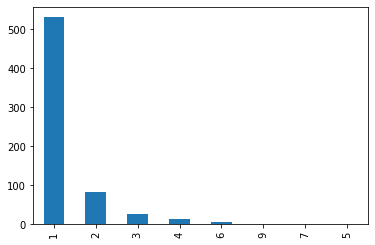

In [21]:
familias.value_counts().value_counts().plot.bar()

Como muitas das familia possuem poucos um membro, podemos agrupar todos as instancias que nao possuem pelo menos dois outros familiares a bordo sob um unico identificador - 0.

In [22]:
tmp = familias.to_frame("Familia")
tmp = tmp.assign(FrequenciaFamilia=tmp.groupby('Familia')['Familia'].transform('count'))
#Familias com pelo menos tres pessoas
familias_de_tres = tmp[tmp["FrequenciaFamilia"] > 3]["Familia"]

In [23]:
#Mapa com NomeFamilia -> Identificador
familias_map = {familia: identifier + 2 for identifier, familia in enumerate(familias_de_tres.unique())}

In [24]:
df = df.assign(Familia=df["Name"].str.extract(familia_pattern, expand=False).map(familias_map).fillna(1).astype(int))

Agora que criamos o atributo `Family` podemos remover o atributo `Name`

In [25]:
df.drop(columns=["Name"], inplace=True)

In [26]:
df.head(1)

Survived  Pclass  Sex   Age  SibSp  Parch     Ticket  Fare  Embarked  \
0         0       3    0  22.0      1      0  A/5 21171  7.25         1   

   Familia  
0        1

#### Ticket

In [27]:
df["Ticket"].value_counts().head()

1601        7
CA. 2343    7
347082      7
347088      6
CA 2144     6
Name: Ticket, dtype: int64

Existem muitos tickets duplicados, presume-se entao que pessoas com mesmo ticket sejam da mesma familia ou estejam alocados na mesma cabine. 

Como essa semantica não é clara e o tipo de dado é misto, foi optado **descartar** esse atributo e simplificar o modelo

In [28]:
df.drop(columns=["Ticket"], inplace=True)

## Identificando outliers

Como a maioria das colunas possuem valores categoricos, precisamos procurar outliers apenas nos atributos `Age` e `Fare`

### Outliers no atributo `Age`

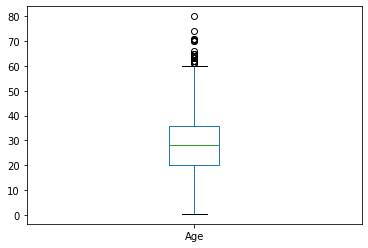

In [29]:
df["Age"].plot.box()

Iremos adotar a politica de separar idades em faixas, logo os poucos outliers que existem nao irao afetar drasticamente os resultados - dependendo do algoritmo utilizado.

### Outliers no atributo `Fare`

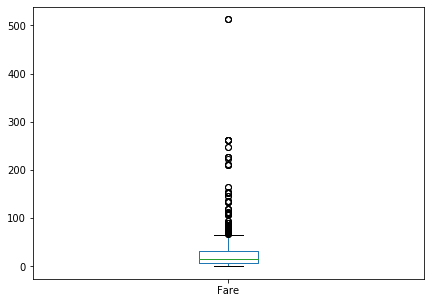

In [30]:
df["Fare"].plot.box(figsize=[7,5])

#### Taxa de sobrevivencia dos 20 individuos que pagaram mais

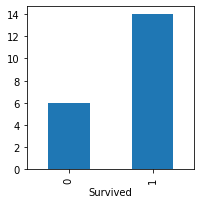

In [31]:
df.sort_values(by="Fare",ascending=False).head(20).groupby("Survived")["Survived"].count().plot.bar(figsize=[3,3])

A maioria das pessoas que pagaram os 20 valores mais altos sobreviveram. 

Como esses outliers sao dados reais que realmente tiveram forte influencia no resultado por serem outliers, nao vamos substitui-los por metricas ou algo semelhante.

### Dividindo faixas de `Age`

Presupoe-se que o valor real da idade importa menos que a faixa etaria do individuo. Para refletir essa realidade no modelo a idade sera dividada em faixas.

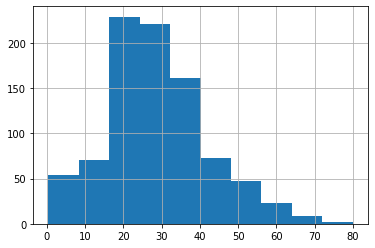

In [32]:
df["Age"].hist()

Iremos dividir idades em faixas que fazem sentido na vida real e tentando evitar desbalanceamento:

- [0, 3)
- [3, 8)
- [8, 15)
- [15, 20)
- [20, 30)
- [30, 45)
- [45, 60)
- [60, df["Age"].max()]

#### Balanceamento das faixas

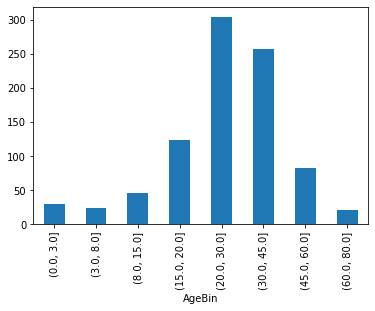

In [33]:
bins = [0, 3, 8, 15, 20, 30, 45, 60, df["Age"].max()]
df['AgeBin'] = pd.cut(df['Age'], bins)
df.groupby("AgeBin")["AgeBin"].count().plot.bar()

#### Taixa de sobrevivencia por faixa de idade

Para verificar a teoria de que a taxa de sobrevivencia esta atrelada a faixa de idade podemos visualizar as porcentagens  de sobreviventes por faixa

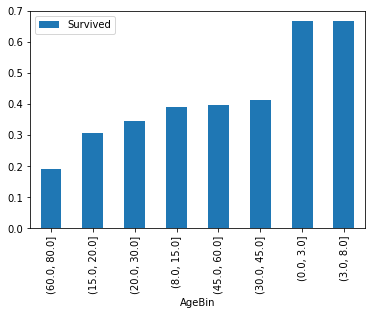

In [34]:
df[['AgeBin', 'Survived']].groupby(['AgeBin'], as_index=True).mean().sort_values(by='Survived').plot.bar()

#### Substituindo faixas por seus ids

In [35]:
faixa_idade_map = {faixa: identifier for identifier, faixa in enumerate(df["AgeBin"].unique())}
df = df.assign(FaixaIdade=df["AgeBin"].map(faixa_idade_map).astype(int))
df.drop(columns=["AgeBin", "Age"],inplace=True)

In [36]:
df.head(5).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 9 columns):
Survived      5 non-null int64
Pclass        5 non-null int64
Sex           5 non-null int64
SibSp         5 non-null int64
Parch         5 non-null int64
Fare          5 non-null float64
Embarked      5 non-null int64
Familia       5 non-null int64
FaixaIdade    5 non-null int64
dtypes: float64(1), int64(8)
memory usage: 400.0 bytes


### Dividindo faixas de `Fare`

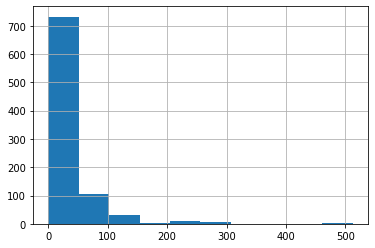

In [37]:
df["Fare"].hist()

In [38]:
# Divisao de fares em faixas
FaixaFare = pd.cut(df["Fare"], 10)
# Substituicao da literal da faixa por seu id
faixa_fare_map = {faixa: identifier for identifier, faixa in enumerate(FaixaFare.unique())}
# Adicao da coluna FaixaFare
df = df.assign(FaixaFare = FaixaFare.map(faixa_fare_map).astype(int))
# Remocao da coluna Fare
df.drop(columns=["Fare"], inplace=True)

In [39]:
df.head(4)

Survived  Pclass  Sex  SibSp  Parch  Embarked  Familia  FaixaIdade  \
0         0       3    0      1      0         1        1           0   
1         1       1    1      1      0         0        1           1   
2         1       3    1      0      0         1        1           0   
3         1       1    1      1      0         1        1           1   

   FaixaFare  
0          0  
1          1  
2          0  
3          1

## Analise de correlacao

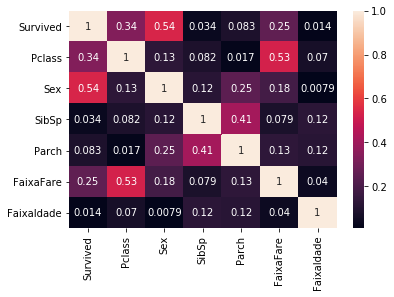

In [40]:
features = ['Survived', 'Pclass', 'Sex', 'SibSp',
       'Parch', 'FaixaFare', 'FaixaIdade']

corr = df[features].corr().abs()
sns.heatmap(corr, annot=True)

Os atributos `SibSp` e `Parch` possuem alta correlacao entre si e baixa correlacao com todos os outros atributos.
O dicionario de dados apresenta as seguintes definicioes:

- **SibSp**: Numero de irmaos e conjuges a bordo
- **Parch**: Numero de pais e filhos a bordo

Ou seja esses atributos estão semanticamente relacionados

Podemos gerar novos atributos `TamanhoFamilia` e `Sozinho` atravez da combinação de `SibSp` e `Parch` e manter apenas os atributos que as maiores correlaçoes com `Survived`

### Combinando `SibSp` e `Parch`

In [41]:
df = df.assign(
        TamanhoFamilia=(df["Parch"] + df["SibSp"]) + 1,
        Sozinho=((df["Parch"] + df["SibSp"]).eq(0).astype("int"))
)

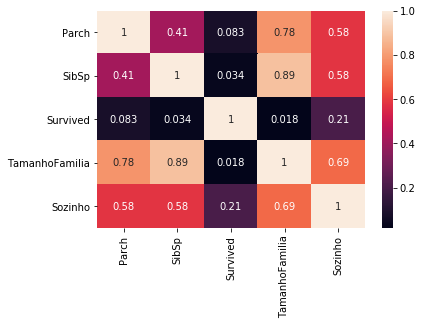

In [42]:
sns.heatmap(df[["Parch", "SibSp", "Survived", "TamanhoFamilia", "Sozinho"]].corr().abs(), annot=True)

Note que de todas as combinações o atributo gerado `Sozinho` teve a maior correlação com `Survived`, logo sera optado por mante-lo e descartar `Parch`, `SibSp` e `TamanhoFamilia`

In [43]:
df.drop(columns=["TamanhoFamilia", "Parch", "SibSp"], inplace=True)

# Modelagem e treinamento

In [44]:
df.head(3)

Survived  Pclass  Sex  Embarked  Familia  FaixaIdade  FaixaFare  Sozinho
0         0       3    0         1        1           0          0        0
1         1       1    1         0        1           1          1        0
2         1       3    1         1        1           0          0        1

Principais pontos para decisao:

- Todos atributos sao categoricos ou foram transformados em atributos categoricos durante a fase de pre-processamento.
- Senso comum sugere que o processo de selecao daqueles que sobrevivem a uma catastrofe como o afundar do Titanic assemelha-se a uma triagem - mulheres e criancas da primeira classe provavelmente sobreviverao, etc.

Essas caracteristicas sao ideais para utilização de **Arvores de Decisão**, pois cada dimensão possui um dominio de poucos valores discretos e um processo de triagem e linearmente separavel, o que possibilita que arvores simples ( poucos niveis ) tenham boa performance no caso em que os dados sao linearmente separaveis.

Em geral [**RandomForest** tem perfomance melhor que arvores de decisao treinadas individualmente](https://towardsdatascience.com/why-random-forests-outperform-decision-trees-1b0f175a0b5), logo sera usado esse metodo.

Como outliers foram eliminados atraves de discretizacao e a maioria dos atributos sao categoricos, **KNN** tambem soa um bom metodo para classificacao desse dataset.

## Separando train e test

In [1786]:
features = ["Pclass","Sex","Embarked","Familia","FaixaIdade","FaixaFare","Sozinho"]
df_train, df_test = sk.model_selection.train_test_split(df, test_size=0.2)
x = df_train[features]
y = df_train["Survived"]

## Testando arvore de decisao com Random Forest

### Aplicando o classificador

In [1894]:
dt = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=20)
dt.fit(x, y)

X = df_test[features]
Y = df_test["Survived"]

### Analisando resultados

In [47]:
# Helper para extrair metricas
def metricas_resultado(y_true, y_predicted):
    matriz_confusao = sk.metrics.confusion_matrix(y_true, y_predicted )
    [[tn, fp],[fn, tp]] = matriz_confusao

    return {
        "Falso negativos": fn,
        "Falso positivos": fp,
        "Sensibilidade": tp / ( tp + fp) * 100,
        "Especificidade": tn / (tn + fn) * 100,
        "Precisao":  sk.metrics.precision_score(y_true, y_predicted),
        "Acuracia":  sk.metrics.accuracy_score(y_true, y_predicted),
        "f1": sk.metrics.f1_score(y_true, y_predicted),
    }

In [1895]:
metricas_resultado(df_test["Survived"], dt.predict(df_test[features]))

{'Falso negativos': 22,
 'Falso positivos': 10,
 'Sensibilidade': 83.33333333333334,
 'Especificidade': 81.35593220338984,
 'Precisao': 0.8333333333333334,
 'Acuracia': 0.8202247191011236,
 'f1': 0.7575757575757577}

### Otimizando altura da arvore

Durante testes foi notado que o parametro max_depth influencia bastante as metricas do classificador, logo foi optado por visualizar estatisticamente esses resultados e escolher um max_depth apropriado

In [1804]:
values = []
for i in range(1,30):
    #Para cada max_depth entre 1 e 30, guarde em values o valor medio das metricas ao longo de 10 ciclos
    average = {}
    for j in range(0,5):
        dt = RandomForestClassifier(n_estimators=100, max_depth=i, criterion="gini")
        dt.fit(x, y)
        X = df_test[features]
        Y = df_test["Survived"]
        metricas = metricas_resultado(df_test["Survived"], dt.predict(df_test[features]))
        for metrica in metricas:
            metricas[metrica] = metricas[metrica] if metricas[metrica] > 1 else metricas[metrica] * 100
        for metrica in metricas:
            try:
                average[metrica] = (average[metrica] + metricas[metrica])/2
            except:
                average[metrica] = metricas[metrica]
    values.append({
        **average,
        "it": i
    })

In [1805]:
df_metrics = pd.DataFrame(values).set_index("it")

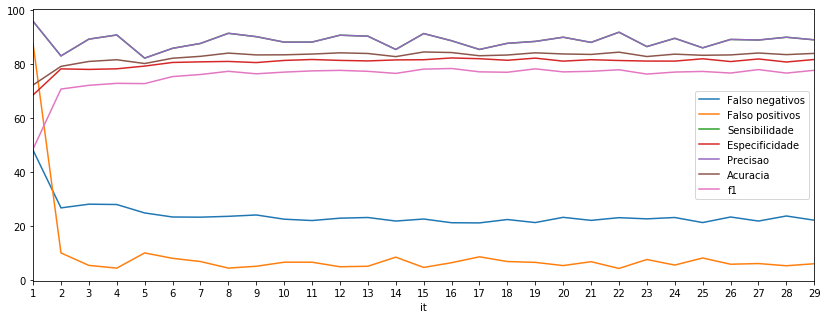

In [1806]:
df_metrics.plot.line(figsize=[14,5], xticks=range(1,30))

Um **max_depth de 8** esta dentro do range no qual as metricas estabilizaram, alem de representar arvores relativamente simples, logo podemos escolher esse valor como altura definitiva.

In [1862]:
dt = RandomForestClassifier(n_estimators=100, max_depth=8, criterion="gini")
dt.fit(x, y)

X = df_test[features]
Y = df_test["Survived"]
metricas_resultado(df_test["Survived"], dt.predict(df_test[features]))

{'Falso negativos': 24,
 'Falso positivos': 2,
 'Sensibilidade': 96.0,
 'Especificidade': 81.25,
 'Precisao': 0.96,
 'Acuracia': 0.8539325842696629,
 'f1': 0.7868852459016393}

## Visualizando uma das arvores criadas
Nao seria pratico visualizar todas as arvores da random forest, podemos entao escolher uma arbritraria.

In [1863]:
estimator = dt.estimators_[0]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [1864]:
Image(filename = 'tree.png', width=3000, height=3000)

OBS: Quanto mais quente a cor de um no, mais instancias do seu grupo morreram. 

### Resultado final para random forest

In [1867]:
metricas_resultado(df_test["Survived"], dt.predict(df_test[features]))

{'Falso negativos': 24,
 'Falso positivos': 2,
 'Sensibilidade': 96.0,
 'Especificidade': 81.25,
 'Precisao': 0.96,
 'Acuracia': 0.8539325842696629,
 'f1': 0.7868852459016393}

## Testando classificacao com KNN

In [1868]:
n = KNeighborsClassifier(n_neighbors=3)
n.fit(x, y)

X = df_test[features]
Y = df_test["Survived"]

In [1869]:
metricas_resultado(Y,n.predict(X))

{'Falso negativos': 24,
 'Falso positivos': 18,
 'Sensibilidade': 72.72727272727273,
 'Especificidade': 78.57142857142857,
 'Precisao': 0.7272727272727273,
 'Acuracia': 0.7640449438202247,
 'f1': 0.6956521739130435}

 Como esse algoritmo nao possui muitos paramentros, podemos buscar o valor de K que garante a melhor performance.

### Otimizando numero de vizinhos

In [1870]:
values = []
for i in range(1,22,2):
    #Para cada max_depth entre 1 e 30, guarde em values o valor medio das metricas ao longo de 10 ciclos
    average = {}
    for j in range(0,3):
        n = KNeighborsClassifier(n_neighbors=i)
        n.fit(x, y)

        X = df_test[features]
        Y = df_test["Survived"]
        metricas = metricas_resultado(df_test["Survived"], n.predict(df_test[features]))
        for metrica in metricas:
            metricas[metrica] = metricas[metrica] if metricas[metrica] > 1 else metricas[metrica] * 100
        for metrica in metricas:
            try:
                average[metrica] = (average[metrica] + metricas[metrica])/2
            except:
                average[metrica] = metricas[metrica]
    values.append({
        **average,
        "it": i
    })

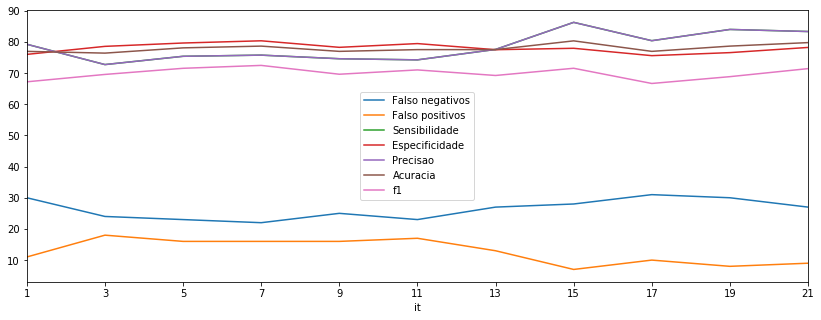

In [1871]:
df_metrics = pd.DataFrame(values).set_index("it")
df_metrics.plot.line(figsize=[14,5], xticks=range(1,22,2))

De acordo com o grafico o valor K=15 oferece os melhores resultados, pois apos esse ponto a medida F1 passa a cair.

### Resultado final KNN

In [1876]:
n = KNeighborsClassifier(n_neighbors=15)
n.fit(x, y)
X = df_test[features]
Y = df_test["Survived"]
metricas_resultado(Y, n.predict(X))

{'Falso negativos': 28,
 'Falso positivos': 7,
 'Sensibilidade': 86.27450980392157,
 'Especificidade': 77.95275590551181,
 'Precisao': 0.8627450980392157,
 'Acuracia': 0.8033707865168539,
 'f1': 0.7154471544715448}

## Comparando KNN e RandomForest

In [1884]:
metricas_knn = metricas_resultado(Y, n.predict(X))
metricas_forest = metricas_resultado(Y, dt.predict(X))

for metrica in metricas_knn:
    metricas_knn[metrica] = metricas_knn[metrica] if metricas_knn[metrica] > 1 else metricas_knn[metrica] * 100
for metrica in metricas_forest:
    metricas_forest[metrica] = metricas_forest[metrica] if metricas_forest[metrica] > 1 else metricas_forest[metrica] * 100

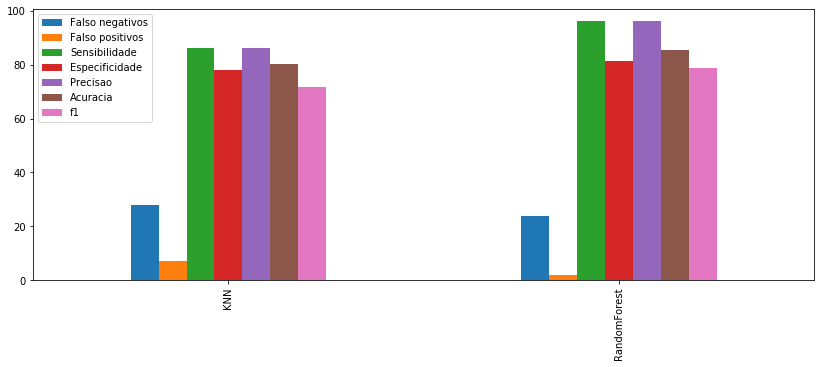

In [1889]:
df_comparacao = pd.DataFrame([metricas_knn, metricas_forest], index=["KNN", "RandomForest"])
df_comparacao.plot.bar(figsize=[14,5])